In [40]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18, resnet50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transforms for dataset
transform = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
train_dataset = ImageFolder(root='/home/iai/Desktop/Jeewon/Study/Conference/Active_Learning/data/splitted_two/train', transform=transform)
test_dataset = ImageFolder(root='/home/iai/Desktop/Jeewon/Study/Conference/Active_Learning/data/splitted_two/test', transform=transform)

In [41]:
print(len(train_dataset))
print(len(test_dataset))

3994
998


In [42]:
import torch.nn as nn
from torchvision.models import resnet18

# Define ResNet model
class ResNet18(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet18, self).__init__()
        self.resnet18 = torchvision.models.resnet18(pretrained=True)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.resnet18.conv1(x)
        x = self.resnet18.bn1(x)
        x = self.resnet18.relu(x)
        x = self.resnet18.maxpool(x)

        x = self.resnet18.layer1(x)
        x = self.resnet18.layer2(x)
        x = self.resnet18.layer3(x)
        x = self.resnet18.layer4(x)

        x = self.resnet18.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = ResNet18(num_classes=2).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, optimizer, labeled_loader):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    total = 0
    for images, labels in labeled_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        train_acc += (predicted == labels).sum().item()
    train_loss /= len(labeled_loader)
    train_acc /= total
    return train_loss, train_acc

In [43]:
# f1 score compute
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

test_acc_300 = []
test_precision_300 = []
test_recall_300 = []
test_f1_300 = []

num_initial_samples = 300
epochs = int(len(train_dataset) / 300) + 1 # 14
batch_size = 2

# Define initial labeled dataset
labeled_indices = torch.randperm(len(train_dataset))[:num_initial_samples]
labeled_dataset = torch.utils.data.Subset(train_dataset, labeled_indices)

unlabeled_indices = torch.arange(len(train_dataset))[~torch.eq(torch.arange(len(train_dataset)).unsqueeze(1), labeled_indices).any(1)]
unlabeled_dataset = torch.utils.data.Subset(train_dataset, unlabeled_indices)

# Define data loaders
labeled_loader = DataLoader(labeled_dataset, batch_size=32, shuffle=True)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Active learning loop
for epoch in range(epochs):
    print("Query number:", epoch+1)
    
    # Train model on labeled dataset
    train_loss, train_acc = train(model, optimizer, labeled_loader)
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")    

   # Evaluate model on test dataset
    with torch.no_grad():
        test_loss = 0.0
        test_acc = 0.0
        total = 0
        y_true = []
        y_pred = []
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            test_acc += (predicted == labels).sum().item()
            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())
        test_loss /= len(test_loader)
        test_acc /= total
        test_acc_300.append(test_acc)
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average = 'binary')
        cm = confusion_matrix(y_true, y_pred)
        print("Confusion Matrix  : {}".format(cm))
        # TN FP
        # FN TP
        test_precision_300.append(precision)
        test_recall_300.append(recall)
        test_f1_300.append(f1)
        print(f"Test Precision: {precision.item():.4f}, Test Recall: {recall.item():.4f}, Test F1 Score: {f1.item():.4f}")
    
    
    if epoch == (epochs-1):
        break
    
    # Make model predictions on unlabeled dataset
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, _ in unlabeled_loader:
            images = images.to(device)
            output = model(images)
            predictions.append(output)
    predictions = torch.cat(predictions, dim=0)

    # Select samples to label using entropy-based method
    entropy = -torch.sum(torch.softmax(predictions, dim=1) * torch.log(torch.softmax(predictions, dim=1)), dim=1)
    if epoch == (epochs-2):
        _, idx = torch.topk(entropy, k = (len(train_dataset)-3900)) # select top 300 
    else:
        _, idx = torch.topk(entropy, k = 300) # select top 300
        
    labeled_indices = torch.cat([labeled_indices, unlabeled_indices[idx]])
    unlabeled_indices = unlabeled_indices[~torch.eq(unlabeled_indices.unsqueeze(1), unlabeled_indices[idx]).any(1)]

    labeled_dataset = torch.utils.data.Subset(train_dataset, labeled_indices)
    unlabeled_dataset = torch.utils.data.Subset(train_dataset, unlabeled_indices)
    print("Updated Length of labeled dataset : ",len(labeled_dataset))
    print("Length of unlabeled dataset : ",len(unlabeled_dataset))
    print("-----------------------------------------------------------")

    # Update labeled and unlabeled data loaders
    labeled_loader = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
    if len(unlabeled_dataset) <=0 :
        pass
    else:
        unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)

Query number: 1
Train Loss: 1.0715, Train Accuracy: 0.6400
Test Loss: 0.7000, Test Accuracy: 0.7395
[[ 42 209]
 [ 51 696]]
Test Precision: 0.7691, Test Recall: 0.9317, Test F1 Score: 0.8426
Updated Length of labeled dataset :  600
Length of unlabeled dataset :  3394
-----------------------------------------------------------
Query number: 2
Train Loss: 0.6524, Train Accuracy: 0.6900
Test Loss: 0.6441, Test Accuracy: 0.7485
[[  0 251]
 [  0 747]]
Test Precision: 0.7485, Test Recall: 1.0000, Test F1 Score: 0.8562
Updated Length of labeled dataset :  900
Length of unlabeled dataset :  3094
-----------------------------------------------------------
Query number: 3
Train Loss: 0.6294, Train Accuracy: 0.7256
Test Loss: 0.6019, Test Accuracy: 0.7034
[[ 21 230]
 [ 66 681]]
Test Precision: 0.7475, Test Recall: 0.9116, Test F1 Score: 0.8215
Updated Length of labeled dataset :  1200
Length of unlabeled dataset :  2794
-----------------------------------------------------------
Query number: 4
Tr

In [44]:
print(test_f1_300)

[0.8426150121065376, 0.856160458452722, 0.8214716525934861, 0.8548479632816982, 0.8540229885057472, 0.8522139160437032, 0.856160458452722, 0.856160458452722, 0.8267954133977067, 0.8363636363636364, 0.8353837141183362, 0.828861061419201, 0.856160458452722, 0.856160458452722]


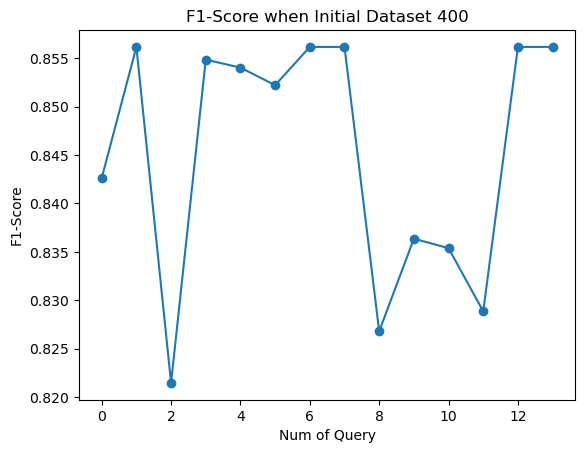

In [45]:
from matplotlib import pyplot as plt

plt.plot(test_f1_300, marker = 'o')
plt.xlabel("Num of Query")
plt.ylabel("F1-Score")
plt.title('F1-Score when Initial Dataset 400')
plt.show()